In [1]:
import math, glob, random, os, time
import pydicom
import cv2
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from functools import partialmethod
import seaborn as sns

### Config

In [2]:
class Config():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    size = 256
    num_images = 64
    base_path = Path('/home/RSNA_MICCAI_Brain_Tumor/data')
    assert base_path.exists(), f'{base_path} does not exist'
    models_path = Path('/home/RSNA_MICCAI_Brain_Tumor/models')
    assert models_path.exists()
    seed = 42
    test_size = 0.1
    clahe=False
    mri_types = ['FLAIR','T1w','T1wCE','T2w']
    batch_size = 8
    num_workers = 7
    epochs = 18
    extra_check_epochs = [14,15]
    check_frequency = 4
    lr=1e-4
    
cfg = Config()

In [3]:
cfg.device

device(type='cuda')

### Functions for loading images

In [4]:
# manual transformations
def brightness(X, gamma_factor = 0.35):
    """
    Changing the brighness of a image using power-law gamma transformation.
    Gain and gamma are chosen randomly for each image channel.
    
    Gain chosen between [0.8 - 1.2]
    Gamma chosen between [0.8 - 1.2]
    
    new_im = gain * im^gamma
    """
    
    X_new = np.zeros(X.shape)
    gain, gamma = (1.2 - gamma_factor) * np.random.random_sample(2,) + gamma_factor
    for c in range(X.shape[-1]):
        im = X[:,:,:,c]        
        im_new = np.sign(im)*gain*(np.abs(im)**gamma)
        X_new[:,:,:,c] = im_new 
    
    return X_new

def flip3D(X):
    """
    Flip the 3D image respect one of the 3 axis chosen randomly
    """
    choice = np.random.randint(4)
    if choice == 0: # flip on x
        X_flip = X[::-1, :, :, :]
    elif choice == 1: # flip on y
        X_flip = X[:, ::-1, :, :]
    elif choice == 2: # flip on z
        X_flip = X[:, :, ::-1, :]
    else:
        X_flip = X
        
    return np.flip(X_flip,axis=0).copy()

In [5]:
def load_dicom_image(path, img_size=cfg.size, clahe=False):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    max_data = np.max(data)
    min_data = np.min(data)
    if min_data == max_data:
        data = np.zeros((img_size,img_size))
        return data
    data = data - min_data
    if max_data != 0:
        data = data / (max_data - min_data) 
    
    #data = (data * 255).astype(np.uint8)
    data = cv2.resize(data, (img_size, img_size))
    return data

In [6]:
def load_dicom_images_3d(scan_id, num_imgs=cfg.num_images, img_size=cfg.size, mri_type="FLAIR", split="train", clahe=False):

    files = sorted(glob.glob(f"{cfg.base_path}/{split}/{scan_id}/{mri_type}/*.dcm"))
    assert len(files) > 0
    
    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, clahe=False) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
    img3d = np.expand_dims(img3d[:,:,:], 0)
    # Transforms
    img3d = flip3D(brightness(img3d))
#     if convert_vertical_flag:
#         img3d_vert = convert_vertical(img3d, size=img3d.shape[0])
#         img3d = np.concatenate([img3d, img3d_vert], axis=-1)
    return img3d

In [7]:
sample_image_0 = load_dicom_images_3d("00000")
sample_image_0.shape

(1, 256, 256, 64)

(-0.5, 255.5, 255.5, -0.5)

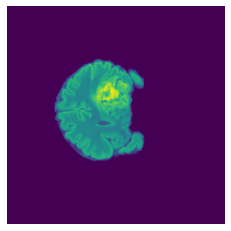

In [8]:
plt.imshow(sample_image_0.squeeze()[:,:,0])
plt.axis('off')

### Seeding

In [9]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(cfg.seed)

### Tabular Data

In [10]:
train_df = pd.read_csv(f"{cfg.base_path}/train_labels.csv")
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [11]:
train_df = train_df.drop(train_df[train_df['BraTS21ID'].isin([109, 123, 709])].index)
train_df

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


### Train / Test Split

In [12]:
df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=cfg.test_size, 
    random_state=42, 
    stratify=train_df["MGMT_value"],
)

In [13]:
len(df_valid) / len(df_train)

0.11281070745697896

In [14]:
df_valid = df_valid.append(pd.DataFrame([{'BraTS21ID': 1, 'MGMT_value': 1}, {'BraTS21ID': 13, 'MGMT_value': 1}]))

In [15]:
len(df_valid) / len(df_train)

0.11663479923518165

### Dataset

In [16]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split, clahe=cfg.clahe)
        else:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train", clahe=cfg.clahe)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}


In [17]:
df_train.loc[:,"MRI_Type"] = 'FLAIR'
sample_ds = Dataset(df_train['BraTS21ID'], df_train['MGMT_value'], df_train['MRI_Type'])

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [18]:
sample_ds[0]['X'].shape

torch.Size([1, 256, 256, 64])

### Model

In [19]:
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)

In [20]:
def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

class SimpleBlock(nn.Module):
    
    def __init__(self, in_planes, out_planes, drop=None):
        super().__init__()
        self.conv = conv3x3x3(in_planes, out_planes, stride=1)
        self.relu = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool3d(kernel_size=2)
        self.bn = nn.BatchNorm3d(out_planes)
        if drop != None:
            self.drop = nn.Dropout(drop)
        else:
            self.drop = None
        
    def forward(self, x):
        x = self.bn(self.maxpool(self.relu(self.conv(x))))
        if self.drop != None:
            x = self.drop(x)
        return x

class CustomModel(nn.Module):

    def __init__(self):
        super().__init__()
        in_planes = 1
        out_planes = 32
        self.block1 = SimpleBlock(1, 64)
        self.block2 = SimpleBlock(64, 128, drop=0.02)
        self.block3 = SimpleBlock(128, 256, drop=0.03)
#         self.block4 = SimpleBlock(256, 512, drop=0.04)
        self.avg = nn.AdaptiveAvgPool3d((4, 1, 1))
        self.fc = nn.Linear(1024, 1024)
        self.relu = nn.ReLU()
        self.regressor = nn.Linear(1024, 1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
#         x = self.block4(x)
        x = self.avg(x).view(x.shape[0], -1)
        x = self.relu(self.fc(x))
        x = self.regressor(x)
        x = torch.sigmoid(x)
        return x

In [21]:
m = nn.AdaptiveAvgPool3d((2,1,1))
a = torch.randn([4, 512, 4, 16, 16])
m(a).shape

torch.Size([4, 512, 2, 1, 1])

In [22]:
def create_model():
    model = CustomModel()
    model.to(cfg.device)
    return model

In [23]:
sample_model = CustomModel()
sample_model.to(cfg.device)
torch.backends.cudnn.enabled = False
sample_data = torch.randn([4, 1, 64, 256, 256]).to(cfg.device)
sample_model(sample_data).shape

torch.Size([4, 1])

### Trainer

In [24]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = -np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):  
        tbar = tqdm(range(1, epochs + 1), total=epochs)
#         self.lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=int(len(train_loader) / 2), T_mult=1, eta_min=0.0001, last_epoch=-1)
        self.lr_sched = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=epochs)
        self.lrs = []
        
        for n_epoch in tbar:
            
            self.info_message("EPOCH: {}", n_epoch)
            tbar.set_description(f'EPOCH: {n_epoch}')
            
            train_loss, train_time = self.train_epoch(train_loader, valid_loader, n_epoch, save_path)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.print_valid_message(valid_loss, valid_auc, valid_time, n_epoch)
            
            self.check_and_save(valid_loss, valid_auc, valid_time, n_epoch, save_path)
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
        plt.plot(self.lrs)
        
    def check_and_save(self, valid_loss, valid_auc, valid_time, n_epoch, save_path):
        # if True:
        # if self.best_valid_score < valid_auc: 
        if self.best_valid_score < valid_auc and valid_auc > 0.5: 
            self.save_model(n_epoch, save_path, valid_loss, valid_auc)
            self.info_message(
                 "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                self.best_valid_score, valid_loss, self.lastmodel
            )
            self.best_valid_score = valid_auc
            self.n_patience = 0
        else:
            self.n_patience += 1
            
    def print_valid_message(self, valid_loss, valid_auc, valid_time, n_epoch):
        self.info_message(
            "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
            n_epoch, valid_loss, valid_auc, valid_time
        )
            
    def train_epoch(self, train_loader, valid_loader, n_epoch, save_path):
        self.model.train()
        t = time.time()
        sum_loss = 0

        tbar = tqdm(enumerate(train_loader, 1), total=len(train_loader))
        
        scaler = torch.cuda.amp.GradScaler() # fp16
        for step, batch in tbar:
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)
                
#             loss.backward()
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

            sum_loss += loss.detach().item()
#             torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
#             self.optimizer.step()
            self.lr_sched.step()
            current_lr = self.optimizer.param_groups[0]["lr"]
            self.lrs.append(
                current_lr
            )
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
            if n_epoch in cfg.extra_check_epochs:
                if step % cfg.check_frequency == 0:
                    valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
                    self.check_and_save(valid_loss, valid_auc, valid_time, n_epoch, save_path)
                    self.print_valid_message(valid_loss, valid_auc, valid_time, n_epoch)
            
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        tbar = tqdm(enumerate(valid_loader, 1), total=len(valid_loader))
        for step, batch in tbar:
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = torch.sigmoid(self.model(X).squeeze(1))
                loss = self.criterion(outputs, targets)
                print('outputs', outputs.mean().item(), outputs.std().item())
                print('targets', targets.mean().item(), targets.std().item())
                
                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = str(cfg.models_path/f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth")
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [25]:
def loss_func(input, target):
#     return F.binary_cross_entropy_with_logits(input, target) * 0.5 + F.mse_loss(input, target) * 0.5
#     return F.binary_cross_entropy_with_logits(input, target) * 0.2 + dice_loss(input, target) * 0.8
    return F.binary_cross_entropy_with_logits(input, target)

In [26]:
def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
    )

    model = create_model()

    #checkpoint = torch.load("best-model-all-auc0.555.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    criterion = loss_func

    trainer = Trainer(
        model, 
        cfg.device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        cfg.epochs, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        cfg.epochs + 100,
    )
    
    return trainer.lastmodel

In [27]:
!rm -rf {str(cfg.models_path)}/*.pth

In [ ]:
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in cfg.mri_types]
    print(modelfiles)

(523, 3) (61, 3)


,BraTS21ID,MGMT_value,MRI_Type
549,803,0,FLAIR
353,520,1,FLAIR
272,399,0,FLAIR
137,206,0,FLAIR
292,423,0,FLAIR


EPOCH: 1


Train Step 66/66, train_loss: 0.6972


outputs 0.5790032148361206 0.04203316941857338
targets 0.5 0.5238320827484131
outputs 0.5638368725776672 0.041866887360811234
targets 0.6225000023841858 0.5071982145309448
outputs 0.5666916370391846 0.04256221279501915
targets 0.5 0.5238320827484131
outputs 0.5970242619514465 0.03187303990125656
targets 0.6225000023841858 0.5071982145309448
outputs 0.5855703353881836 0.04291509836912155
targets 0.3774999976158142 0.5071982145309448
outputs 0.5994663238525391 0.029365522786974907
targets 0.3774999976158142 0.5071982145309448
outputs 0.5802760124206543 0.04414314404129982
targets 0.6225000023841858 0.5071982145309448
outputs 0.5505014657974243 0.059198979288339615
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7016
[Epoch Train: 1] loss: 0.6972, time: 37.00 s            
[Epoch Valid: 1] loss: 0.7016, auc: 0.5812, time: 6.00 s
auc improved from -inf to 0.7016. Saved model to '/home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e1-loss0.702-auc0.581.pth'
EPOCH: 2


Train Step 66/66, train_loss: 0.6911


outputs 0.5366227626800537 0.038657046854496
targets 0.5 0.5238320827484131
outputs 0.5209648609161377 0.03368842974305153
targets 0.6225000023841858 0.5071982145309448
outputs 0.5294674634933472 0.040799371898174286
targets 0.5 0.5238320827484131
outputs 0.556794285774231 0.03700604662299156
targets 0.6225000023841858 0.5071982145309448
outputs 0.5430525541305542 0.04037254676222801
targets 0.3774999976158142 0.5071982145309448
outputs 0.55387282371521 0.041434116661548615
targets 0.3774999976158142 0.5071982145309448
outputs 0.5372604131698608 0.04279130697250366
targets 0.6225000023841858 0.5071982145309448
outputs 0.5270801782608032 0.039258502423763275
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6961
[Epoch Train: 2] loss: 0.6911, time: 38.00 s            
[Epoch Valid: 2] loss: 0.6961, auc: 0.6331, time: 6.00 s
auc improved from 0.5812 to 0.6961. Saved model to '/home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e2-loss0.696-auc0.633.pth'
EPOCH: 3


Train Step 66/66, train_loss: 0.6895


outputs 0.5557456016540527 0.05306856706738472
targets 0.5 0.5238320827484131
outputs 0.5376508235931396 0.05174835026264191
targets 0.6225000023841858 0.5071982145309448
outputs 0.5430694818496704 0.05814989656209946
targets 0.5 0.5238320827484131
outputs 0.5734963417053223 0.048393264412879944
targets 0.6225000023841858 0.5071982145309448
outputs 0.5608997344970703 0.05932951718568802
targets 0.3774999976158142 0.5071982145309448
outputs 0.5719578266143799 0.050601162016391754
targets 0.3774999976158142 0.5071982145309448
outputs 0.5443964600563049 0.05458928272128105
targets 0.6225000023841858 0.5071982145309448
outputs 0.5424821972846985 0.05817089602351189
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6944
[Epoch Train: 3] loss: 0.6895, time: 38.00 s            
[Epoch Valid: 3] loss: 0.6944, auc: 0.6439, time: 6.00 s
auc improved from 0.6331 to 0.6944. Saved model to '/home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e3-loss0.694-auc0.644.pth'
EPOCH: 4


Train Step 66/66, train_loss: 0.6900


outputs 0.5129159688949585 0.017842313274741173
targets 0.5 0.5238320827484131
outputs 0.507156252861023 0.01583208702504635
targets 0.6225000023841858 0.5071982145309448
outputs 0.5104080438613892 0.015440337359905243
targets 0.5 0.5238320827484131
outputs 0.5135850310325623 0.011570720933377743
targets 0.6225000023841858 0.5071982145309448
outputs 0.5129108428955078 0.015808328986167908
targets 0.3774999976158142 0.5071982145309448
outputs 0.5192797780036926 0.018992409110069275
targets 0.3774999976158142 0.5071982145309448
outputs 0.5098069906234741 0.013117955066263676
targets 0.6225000023841858 0.5071982145309448
outputs 0.5053513646125793 0.008757532574236393
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6977
[Epoch Train: 4] loss: 0.6900, time: 37.00 s            
[Epoch Valid: 4] loss: 0.6977, auc: 0.6374, time: 6.00 s
EPOCH: 5


Train Step 66/66, train_loss: 0.6867


outputs 0.504228949546814 0.009774320758879185
targets 0.5 0.5238320827484131
outputs 0.5005347728729248 0.0014963943976908922
targets 0.6225000023841858 0.5071982145309448
outputs 0.5010330080986023 0.0019196270732209086
targets 0.5 0.5238320827484131
outputs 0.5035892724990845 0.0053212568163871765
targets 0.6225000023841858 0.5071982145309448
outputs 0.501200795173645 0.002372301183640957
targets 0.3774999976158142 0.5071982145309448
outputs 0.5073496103286743 0.01706726662814617
targets 0.3774999976158142 0.5071982145309448
outputs 0.5035192370414734 0.006450282409787178
targets 0.6225000023841858 0.5071982145309448
outputs 0.501187801361084 0.002644789405167103
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Train: 5] loss: 0.6867, time: 38.00 s            
[Epoch Valid: 5] loss: 0.6980, auc: 0.6591, time: 6.00 s
auc improved from 0.6439 to 0.6980. Saved model to '/home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e5-loss0.698-auc0.659.pth'
EPOCH: 

Train Step 66/66, train_loss: 0.6960


outputs 0.5000059008598328 9.537501682643779e-06
targets 0.5 0.5238320827484131
outputs 0.500002384185791 3.565192173482501e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000060796737671 1.2065088412782643e-05
targets 0.5 0.5238320827484131
outputs 0.5000032186508179 7.410880243696738e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000052452087402 8.385286491829902e-06
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000011920928955 1.499791778769577e-06
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000007152557373 1.4441062603509636e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.500001847743988 2.4663650037837215e-06
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Train: 6] loss: 0.6960, time: 38.00 s            
[Epoch Valid: 6] loss: 0.6980, auc: 0.5260, time: 6.00 s
EPOCH: 7


Train Step 66/66, train_loss: 0.6931


outputs 0.5000086426734924 1.6997008060570806e-05
targets 0.5 0.5238320827484131
outputs 0.5000020861625671 3.08355811284855e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000048279762268 8.302959940920118e-06
targets 0.5 0.5238320827484131
outputs 0.5000035762786865 7.555444881290896e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.500007152557373 1.2102794244128745e-05
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000014901161194 1.723167770251166e-06
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000004768371582 8.033212566260772e-07
targets 0.6225000023841858 0.5071982145309448
outputs 0.500001847743988 2.3173038243839983e-06
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Train: 7] loss: 0.6931, time: 37.00 s            
[Epoch Valid: 7] loss: 0.6980, auc: 0.5525, time: 6.00 s
EPOCH: 8


Train Step 66/66, train_loss: 0.6927


outputs 0.5000300407409668 6.794629007345065e-05
targets 0.5 0.5238320827484131
outputs 0.5000064373016357 8.8677525127423e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.500016450881958 3.500718958093785e-05
targets 0.5 0.5238320827484131
outputs 0.5000067353248596 1.3483133443514816e-05
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000173449516296 3.2960655516944826e-05
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000033378601074 3.6670871850219555e-06
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000019073486328 3.0734190659131855e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000115633010864 1.9203171177650802e-05
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Train: 8] loss: 0.6927, time: 37.00 s            
[Epoch Valid: 8] loss: 0.6980, auc: 0.5373, time: 6.00 s
EPOCH: 9


Train Step 66/66, train_loss: 0.6932


outputs 0.5001657605171204 0.0004518074565567076
targets 0.5 0.5238320827484131
outputs 0.5000074505805969 1.2159086509200279e-05
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000120401382446 2.285115078848321e-05
targets 0.5 0.5238320827484131
outputs 0.5000093579292297 1.318728845944861e-05
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000488758087158 0.00011141115101054311
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000178217887878 3.92308174923528e-05
targets 0.3774999976158142 0.5071982145309448
outputs 0.500002920627594 4.4516332309285644e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000149607658386 2.760508687060792e-05
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6981
[Epoch Train: 9] loss: 0.6932, time: 37.00 s            
[Epoch Valid: 9] loss: 0.6981, auc: 0.5855, time: 6.00 s
EPOCH: 10


Train Step 66/66, train_loss: 0.6917


outputs 0.500035285949707 6.654355820501223e-05
targets 0.5 0.5238320827484131
outputs 0.5000067949295044 7.582183570775669e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000054836273193 8.236725079768803e-06
targets 0.5 0.5238320827484131
outputs 0.500008225440979 1.8831880879588425e-05
targets 0.6225000023841858 0.5071982145309448
outputs 0.500028133392334 6.369088805513456e-05
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000094175338745 2.0610577848856337e-05
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000168085098267 3.750929681700654e-05
targets 0.6225000023841858 0.5071982145309448
outputs 0.500013530254364 2.214596315752715e-05
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Train: 10] loss: 0.6917, time: 37.00 s            
[Epoch Valid: 10] loss: 0.6980, auc: 0.3961, time: 6.00 s
EPOCH: 11


Train Step 66/66, train_loss: 0.6906


outputs 0.5048735737800598 0.012484288774430752
targets 0.5 0.5238320827484131
outputs 0.5002224445343018 0.0005418176879175007
targets 0.6225000023841858 0.5071982145309448
outputs 0.5002612471580505 0.00041718283318914473
targets 0.5 0.5238320827484131
outputs 0.5016652345657349 0.0026960927061736584
targets 0.6225000023841858 0.5071982145309448
outputs 0.5024268627166748 0.004008363466709852
targets 0.3774999976158142 0.5071982145309448
outputs 0.50299072265625 0.007171379402279854
targets 0.3774999976158142 0.5071982145309448
outputs 0.5011624097824097 0.00249351654201746
targets 0.6225000023841858 0.5071982145309448
outputs 0.5002509951591492 0.0003178433980792761
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6984
[Epoch Train: 11] loss: 0.6906, time: 37.00 s            
[Epoch Valid: 11] loss: 0.6984, auc: 0.6207, time: 6.00 s
EPOCH: 12


Train Step 66/66, train_loss: 0.6906


outputs 0.5295442342758179 0.04961930960416794
targets 0.5 0.5238320827484131
outputs 0.5013387203216553 0.001547585939988494
targets 0.6225000023841858 0.5071982145309448
outputs 0.5132846832275391 0.03649035841226578
targets 0.5 0.5238320827484131
outputs 0.5172414183616638 0.0389094240963459
targets 0.6225000023841858 0.5071982145309448
outputs 0.5150747895240784 0.025546370074152946
targets 0.3774999976158142 0.5071982145309448
outputs 0.5083448886871338 0.018029669299721718
targets 0.3774999976158142 0.5071982145309448
outputs 0.5036967992782593 0.005597791634500027
targets 0.6225000023841858 0.5071982145309448
outputs 0.5163646936416626 0.030723005533218384
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Train: 12] loss: 0.6906, time: 37.00 s            
[Epoch Valid: 12] loss: 0.6980, auc: 0.5054, time: 6.00 s
EPOCH: 13


Train Step 66/66, train_loss: 0.6915


outputs 0.5048075914382935 0.005751727614551783
targets 0.5 0.5238320827484131
outputs 0.5012933015823364 0.003569455584511161
targets 0.6225000023841858 0.5071982145309448
outputs 0.503078281879425 0.004978571552783251
targets 0.5 0.5238320827484131
outputs 0.518109917640686 0.028827136382460594
targets 0.6225000023841858 0.5071982145309448
outputs 0.505834698677063 0.008878542110323906
targets 0.3774999976158142 0.5071982145309448
outputs 0.5166992545127869 0.03855068236589432
targets 0.3774999976158142 0.5071982145309448
outputs 0.5126983523368835 0.02710782364010811
targets 0.6225000023841858 0.5071982145309448
outputs 0.5038346648216248 0.008437217213213444
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Train: 13] loss: 0.6915, time: 38.00 s            
[Epoch Valid: 13] loss: 0.6980, auc: 0.6602, time: 6.00 s
auc improved from 0.6591 to 0.6980. Saved model to '/home/RSNA_MICCAI_Brain_Tumor/models/FLAIR-e13-loss0.698-auc0.660.pth'
EPOCH: 1

outputs 0.5096980333328247 0.013550641015172005
targets 0.5 0.5238320827484131
outputs 0.5057275891304016 0.016140181571245193
targets 0.6225000023841858 0.5071982145309448
outputs 0.51153564453125 0.021487843245267868
targets 0.5 0.5238320827484131
outputs 0.5288134217262268 0.039297934621572495
targets 0.6225000023841858 0.5071982145309448
outputs 0.5120646953582764 0.027333766222000122
targets 0.3774999976158142 0.5071982145309448
outputs 0.5267882347106934 0.043330226093530655
targets 0.3774999976158142 0.5071982145309448
outputs 0.5270794630050659 0.045195721089839935
targets 0.6225000023841858 0.5071982145309448
outputs 0.5136599540710449 0.030457621440291405
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6970
[Epoch Valid: 14] loss: 0.6970, auc: 0.6494, time: 8.00 s


outputs 0.5 0.0
targets 0.5 0.5238320827484131
outputs 0.5 0.0 valid_loss: 0.7241
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.6935
targets 0.5 0.5238320827484131
outputs 0.5 0.0 valid_loss: 0.7037
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.6935
targets 0.3774999976158142 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7118
targets 0.3774999976158142 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7241
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7153
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Valid: 14] loss: 0.6980, auc: 0.5000, time: 7.00 s


outputs 0.5 0.0
targets 0.5 0.5238320827484131
outputs 0.5 0.0 valid_loss: 0.7241
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.6935
targets 0.5 0.5238320827484131
outputs 0.5 0.0 valid_loss: 0.7037
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.6935
targets 0.3774999976158142 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7118
targets 0.3774999976158142 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7241
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7153
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Valid: 14] loss: 0.6980, auc: 0.5000, time: 7.00 s


outputs 0.5000000596046448 1.6858739115832577e-07
targets 0.5 0.5238320827484131
outputs 0.5 7.300048565639372e-081
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 1.5930011088016727e-08
targets 0.5 0.5238320827484131
outputs 0.5 0.0 valid_loss: 0.7037
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 7.300048565639372e-085
targets 0.3774999976158142 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7118
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000003576278687 1.023619461193448e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 2.107342389479072e-083
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Valid: 14] loss: 0.6980, auc: 0.4924, time: 7.00 s


outputs 0.5000080466270447 1.5214344784908462e-05
targets 0.5 0.5238320827484131
outputs 0.5000011920928955 1.983846232178621e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000021457672119 5.876900559087517e-06
targets 0.5 0.5238320827484131
outputs 0.5 1.5930011088016727e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000014305114746 3.973859293182613e-06
targets 0.3774999976158142 0.5071982145309448
outputs 0.5 1.5930011088016727e-08
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000118017196655 3.278255098848604e-05
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000003576278687 7.419920393658685e-07
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Valid: 14] loss: 0.6980, auc: 0.4648, time: 7.00 s


outputs 0.5004087686538696 0.0010780284646898508
targets 0.5 0.5238320827484131
outputs 0.5000414848327637 6.108498200774193e-05
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000316500663757 7.773684774292633e-05
targets 0.5 0.5238320827484131
outputs 0.5000002384185791 3.846363938464492e-07
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000137090682983 3.855840259348042e-05
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000014305114746 3.328190814499976e-06
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000573396682739 0.00011411662853788584
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000036358833313 7.953914973768406e-06
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6981
[Epoch Valid: 14] loss: 0.6981, auc: 0.3750, time: 7.00 s


outputs 0.5000756978988647 0.00015842406719457358
targets 0.5 0.5238320827484131
outputs 0.5003214478492737 0.0005638462025672197
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000999569892883 0.00018610931874718517
targets 0.5 0.5238320827484131
outputs 0.5000094175338745 2.082491118926555e-05
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000563859939575 0.0001334854168817401
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000290870666504 7.047394319670275e-05
targets 0.3774999976158142 0.5071982145309448
outputs 0.5001351833343506 0.00016685387527104467
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000391602516174 4.435087976162322e-05
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6981
[Epoch Valid: 14] loss: 0.6981, auc: 0.3804, time: 7.00 s


outputs 0.5000755786895752 0.00013464798394124955
targets 0.5 0.5238320827484131
outputs 0.500314474105835 0.0004432624264154583
targets 0.6225000023841858 0.5071982145309448
outputs 0.5001310110092163 0.0002348187699681148
targets 0.5 0.5238320827484131
outputs 0.5000627040863037 0.00015484738105442375
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000690221786499 0.00014651069068349898
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000372529029846 7.000084588071331e-05
targets 0.3774999976158142 0.5071982145309448
outputs 0.5001126527786255 0.00015243282541632652
targets 0.6225000023841858 0.5071982145309448
outputs 0.5002819895744324 0.0002993045200128108
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6981
[Epoch Valid: 14] loss: 0.6981, auc: 0.4134, time: 7.00 s


outputs 0.5000802874565125 0.00013119597861077636
targets 0.5 0.5238320827484131
outputs 0.5001644492149353 0.0001732856035232544
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000611543655396 9.99109324766323e-05
targets 0.5 0.5238320827484131
outputs 0.5000826120376587 0.0001959138608071953
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000371932983398 9.613552538212389e-05
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000295639038086 6.803798896726221e-05
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000475645065308 6.542253686347976e-05
targets 0.6225000023841858 0.5071982145309448
outputs 0.5004302859306335 0.0006405581953004003
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Valid: 14] loss: 0.6980, auc: 0.4459, time: 7.00 s


outputs 0.5002061128616333 0.00035328668309375644
targets 0.5 0.5238320827484131
outputs 0.500312328338623 0.00032053919858299196
targets 0.6225000023841858 0.5071982145309448
outputs 0.5001006126403809 0.00014881891547702253
targets 0.5 0.5238320827484131
outputs 0.5002288818359375 0.0005324030062183738
targets 0.6225000023841858 0.5071982145309448
outputs 0.5000650882720947 0.00017065614520106465
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000741481781006 0.00018886140605900437
targets 0.3774999976158142 0.5071982145309448
outputs 0.5001018047332764 0.00018748354341369122
targets 0.6225000023841858 0.5071982145309448
outputs 0.5014782547950745 0.0026326740626245737
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Valid: 14] loss: 0.6980, auc: 0.4692, time: 7.00 s


outputs 0.526672899723053 0.060973718762397766
targets 0.5 0.5238320827484131
outputs 0.5037518739700317 0.006600319407880306
targets 0.6225000023841858 0.5071982145309448
outputs 0.5074334740638733 0.02049950323998928
targets 0.5 0.5238320827484131
outputs 0.5000147819519043 2.4022772777243517e-05
targets 0.6225000023841858 0.5071982145309448
outputs 0.502579927444458 0.007296558935195208
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000476837158203 0.00011450397141743451
targets 0.3774999976158142 0.5071982145309448
outputs 0.5120195150375366 0.027316492050886154
targets 0.6225000023841858 0.5071982145309448
outputs 0.500424861907959 0.0009496991406194866
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.7008
[Epoch Valid: 14] loss: 0.7008, auc: 0.3815, time: 7.00 s


outputs 0.5000000596046448 2.0524383614883845e-07
targets 0.5 0.5238320827484131
outputs 0.5 1.5930011088016727e-08
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.6935
targets 0.5 0.5238320827484131
outputs 0.5 0.0 valid_loss: 0.7037
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 3.902039935610446e-085
targets 0.3774999976158142 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7118
targets 0.3774999976158142 0.5071982145309448
outputs 0.5000022649765015 6.394287538569188e-06
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7153
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Valid: 14] loss: 0.6980, auc: 0.4946, time: 7.00 s


outputs 0.5 0.0
targets 0.5 0.5238320827484131
outputs 0.5 0.0 valid_loss: 0.7241
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.6935
targets 0.5 0.5238320827484131
outputs 0.5 0.0 valid_loss: 0.7037
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.6935
targets 0.3774999976158142 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7118
targets 0.3774999976158142 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7241
targets 0.6225000023841858 0.5071982145309448
outputs 0.5 0.0 valid_loss: 0.7153
targets 0.7940000295639038 0.43826931715011597
Valid Step 8/8, valid_loss: 0.6980
[Epoch Valid: 14] loss: 0.6980, auc: 0.5000, time: 7.00 s


## Predict Function

In [ ]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=8,
    )
   
    model = create_model()
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = model(batch["X"].to(cfg.device)).cpu().numpy().squeeze()
            print('tmp_pred', tmp_pred)
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

### Ensemble for Validation

In [ ]:
df_valid = df_valid.set_index("BraTS21ID")

In [ ]:
def normalize_results(preds, train):
    return (preds - (preds.mean() - train.mean()))

In [ ]:
df_valid["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  cfg.mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])